# Natural Language Processing 
## Using GCP and AWS on Google PlayStore Review

### Ingest

In [1]:
!pip install --upgrade pip
!pip -q install boto3

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.0.3)


In [2]:
import pandas as pd 
import json 
import os #to set credentials to enviroment 

#AWS Comprehend
import boto3

# Imports the Google Cloud client library for GCP Natrual Language API
from google.cloud import language_v1
from google.cloud.language_v1 import enums
import six

#Benchmark
from sklearn.metrics import confusion_matrix



In [9]:
google_review = pd.read_csv("https://raw.githubusercontent.com/Barneybean/comment_objetivity_analysis/master/googleplaystore_user_reviews.csv")

google_review_df = google_review[["Translated_Review", "Sentiment"]].dropna()[0:50]

google_review_df.head()


,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


## AWS Comprehend

**install boto3**


**Create API Config**

In [4]:
!mkdir -p ~/.aws &&\
  cat /Users/williamgao/Desktop/HW9/credentials.txt > ~/.aws/credentials

!cd ~/.aws &&\
  cat /Users/williamgao/Desktop/HW9/config.txt > ~/.aws/config

In [5]:
comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")


def get_sentiment(text):
  try:
    res = comprehend.detect_sentiment(Text=text, LanguageCode='en')["Sentiment"]
    return res
  except: 
    return None

In [6]:
google_review_df["Translated_Review"].astype(str)

google_review_df["AWS_sentiment"] = google_review_df["Translated_Review"].apply(lambda x: get_sentiment(x))

In [7]:
google_review_df.head()

,Translated_Review,Sentiment,AWS_sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive,NEUTRAL
1,This help eating healthy exercise regular basis,Positive,NEUTRAL
3,Works great especially going grocery store,Positive,POSITIVE
4,Best idea us,Positive,POSITIVE
5,Best way,Positive,POSITIVE


**Compare Sentiment Results**

In [24]:
from sklearn.metrics import confusion_matrix

y_true = google_review_df["Sentiment"]
y_pred = google_review_df["AWS_sentiment"]

cm = confusion_matrix(y_true, y_pred)
cm

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 2,  6,  0,  0, 34,  0]])

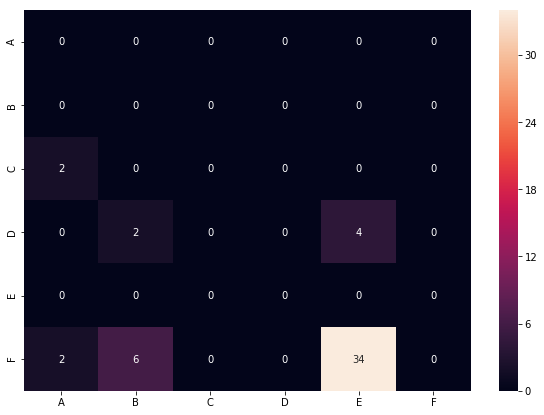

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEF"],
                  columns = [i for i in "ABCDEF"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## GCP Comprehend

In [27]:
!pip install --upgrade -q google-cloud-language

In [30]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/williamgao/Desktop/HW9/flowerautoml-df46bea0c0ef.json"


In [31]:
# import os

def gcp_analyze_sentiment(content):

    client = language_v1.LanguageServiceClient()

    # content = 'Your text to analyze, e.g. Hello, world!'

    if isinstance(content, six.binary_type):
        content = content.decode('utf-8')

    type_ = enums.Document.Type.PLAIN_TEXT
    document = {'type': type_, 'content': content}

    response = client.analyze_sentiment(document)
    sentiment = response.document_sentiment.score
#     return sentiment
    return(sentiment)

In [32]:
google_review_df["GCP_sentiment_score"] = google_review_df["Translated_Review"].apply(lambda x: gcp_analyze_sentiment(x))

In [0]:
google_review_df.head()

,Translated_Review,Sentiment,AWS_sentiment,GCP_sentiment_score
0,I like eat delicious food. That's I'm cooking ...,Positive,NEUTRAL,0.9
1,This help eating healthy exercise regular basis,Positive,NEUTRAL,0.4
3,Works great especially going grocery store,Positive,POSITIVE,0.9
4,Best idea us,Positive,POSITIVE,0.8
5,Best way,Positive,POSITIVE,0.9


In [0]:
google_review_df.loc[ google_review_df["GCP_sentiment_score"] < 0.5, 'GCP_sentiment' ] = 'NEGETIVE'
google_review_df.loc[ google_review_df["GCP_sentiment_score"] >= 0.5, 'GCP_sentiment' ] = 'POSITIVE'



In [0]:
google_review_df.head()

,Translated_Review,Sentiment,AWS_sentiment,GCP_sentiment_score,GCP_sentiment,gcp_euqal_aws
0,I like eat delicious food. That's I'm cooking ...,Positive,NEUTRAL,0.9,POSITIVE,NaN
1,This help eating healthy exercise regular basis,Positive,NEUTRAL,0.4,NEGETIVE,NaN
3,Works great especially going grocery store,Positive,POSITIVE,0.9,POSITIVE,1.0
4,Best idea us,Positive,POSITIVE,0.8,POSITIVE,1.0
5,Best way,Positive,POSITIVE,0.9,POSITIVE,1.0


In [0]:
google_review_df.loc[google_review_df["GCP_sentiment"] == google_review_df["AWS_sentiment"], "gcp_euqal_aws"] = 1
euqual_gcp_aws = google_review_df["gcp_euqal_aws"].sum()
total = len(google_review_df)
identity_ratio_gcp_aws = euqual_gcp_aws/total

identity_ratio_gcp_aws

0.66

In [0]:
google_review_df.loc[google_review_df["GCP_sentiment"] == google_review_df["Sentiment"].str.upper(), "gcp_euqal_origin"] = 1
euqual_gcp_origin = google_review_df["gcp_euqal_aws"].sum()
total = len(google_review_df)
identity_ratio_gcp_origin = euqual_gcp_origin/total

identity_ratio_gcp_origin

0.66

In [0]:
google_review_df.loc[google_review_df["AWS_sentiment"] == google_review_df["Sentiment"].str.upper(), "gcp_euqal_origin"] = 1
equal_aws_origin = google_review_df["gcp_euqal_aws"].sum()
total = len(google_review_df)
identity_ratio_aws_origin = equal_aws_origin/total

identity_ratio_aws_origin

0.66

**The AWS and GCP has some accuracy issue in NLP given the second row in google_review_df**